In [1]:
#load in parent stuff

import nb_load_stuff
from tectModelClass import *

importing Jupyter notebook from tectModelClass.ipynb


In [2]:
#If run through Docker we'll point at the local 'unsupported dir.'
#On hpc, the path should also include a directory holding the unsupported_dan.
import os
import sys

if os.getcwd() == '/workspace/newSlab':
    sys.path.append('../unsupported')

#this does't actually need to be protected. More a reminder it's an interim measure
try:
    sys.path.append('../unsupported')
except:
    pass

In [3]:
from unsupported_dan.utilities import *
from unsupported_dan.utilities import *
from unsupported_dan.interfaces.marker2D import markerLine2D, line_collection


../unsupported/unsupported_dan/utilities/__init__.py:9: UserWarning: 

The utilities module is not supported.
Questions should be addressed to sandd@student.unimelb.edu.au 
 
  Questions should be addressed to sandd@student.unimelb.edu.au \n """
../unsupported/unsupported_dan/interfaces/__init__.py:9: UserWarning: 

The interface module is not supported.
Questions should be addressed to louis.moresi@unimelb.edu.au 
 
  Questions should be addressed to louis.moresi@unimelb.edu.au \n """


In [4]:
import numpy as np
import underworld as uw
from underworld import function as fn
import glucifer
from easydict import EasyDict as edict
import networkx as nx
import operator




## Toy model

In [5]:
mesh = uw.mesh.FeMesh_Cartesian( elementType = ("Q1"), 
                                 elementRes  = (96, 48), 
                                 minCoord    = (-1.0, 0.0), 
                                 maxCoord    = (1.0, 1.0) )


temperatureField = uw.mesh.MeshVariable( mesh=mesh, nodeDofCount=1 )
velocityField = uw.mesh.MeshVariable( mesh=mesh, nodeDofCount=2 )
coordinate = fn.input()


In [6]:
#toy model, 3 plates
############################
#-1        0.0  0.5    1.0
######1##### ###2###  ##3##
            #
             #
###########################

tg = TectModel(mesh, 0, 20, 1)

tg.add_plate(1, velocities = 1)
tg.add_plate(2,velocities = -1)
tg.add_plate(3, velocities = 0)
        
tg.add_left_boundary(1)
tg.add_subzone(1, 2, 0.0, subInitAge=50.0, upperInitAge=10.0)
tg.add_ridge(2, 3, 0.5)
tg.add_right_boundary(3, 30.)

In [7]:
#tg.is_subduction_boundary((1,2))

In [8]:
#tg.is_subduction_boundary(2,1), tg.is_subduction_boundary(3,2)

#tg.subduction_boundary_from_plate(3)
#tg.is_subducting_plate(1)
#
#np.sort(tg.get_boundaries(1)).mean(),  np.sort(tg.get_boundaries(2)).mean()
#tg.subduction_direction(1,2)

#tg.subduction_boundary_from_plate(tg.subduction_direction(2,1))
#tg.subduction_boundary_from_plate(tg.subduction_edge_order(2,1)[0])

In [9]:
plateId =1
len(tg[plateId].keys()) == 1 and len(tg.undirected[plateId].keys()) ==2

False

In [10]:
plateId = 3
for b in tg.connected_plates(plateId ):
    print(b)
    if tg.has_edge(plateId, b) and tg.has_edge(b, plateId):
        pass
    else:
        print(tg.subduction_direction(plateId, b))
        break

2
3


In [11]:
plateId = 2
[i for i in tg.out_edges(plateId)]
#[i for i in tg.in_edges(plateId)]


[(2, 3)]

In [12]:
tg.in_edges(plateId)[0], tg.out_edges(plateId)[0]

((1, 2), (2, 3))

1
('plate 1', array([-1.,  0.]))
2
('plate 2', array([ 0. ,  0.5]))
3
('plate 3', array([ 0.5,  1. ]))



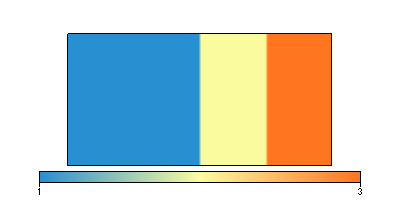

In [13]:
for n in tg.nodes():
    print(n)
    bounds  = np.sort(tg.get_boundaries(n))
    print('plate {}'.format(n), bounds)
    
    
pIdFn = tg.plate_id_fn()
pAgeDict = tg.plate_age_fn() 

fnAge_map = fn.branching.map(fn_key = pIdFn , 
                          mapping = pAgeDict )

fig = glucifer.Figure(figsize=(400, 200))
fig.append( glucifer.objects.Surface(tg.mesh, pIdFn ))
fig.show()

## Physical model

In [14]:
yres = int(md.res)
xres = int(md.res*12) 

mesh = uw.mesh.FeMesh_Cartesian( elementType = (md.elementType),
                                 elementRes  = (xres, yres), 
                                 minCoord    = (ndp.leftLim, 1. - ndp.depth), 
                                 maxCoord    = (ndp.rightLim, 1.)) 

temperatureField    = uw.mesh.MeshVariable( mesh=mesh,         nodeDofCount=1 )

velocityField = uw.mesh.MeshVariable( mesh=mesh,         nodeDofCount=2)

In [15]:
#ndp.depth*2900.

## Build plate model

In [16]:
tg = TectModel(mesh, 0, 20, 1)

tg.add_plate(1, velocities = 1)
tg.add_plate(2,velocities = -1)
tg.add_plate(3,velocities = -1)

In [17]:
tg.add_left_boundary(1)
tg.add_subzone(1, 2, ndp.subZoneLoc, subInitAge=ndp.slabMaxAge, upperInitAge=ndp.opMaxAge)
tg.add_subzone(3, 2., 0.4, subInitAge=ndp.slabMaxAge, upperInitAge=ndp.opMaxAge)

tg.add_right_boundary(3, 0.)

## Build plate age


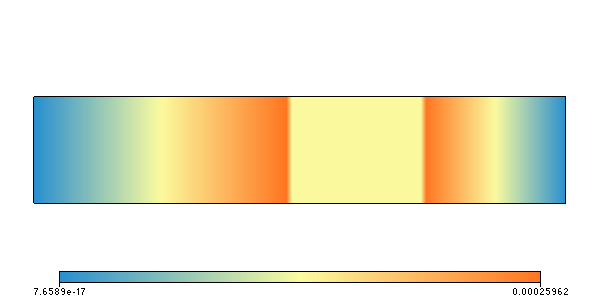

In [18]:
pIdFn = tg.plate_id_fn()
pAgeDict = tg.plate_age_fn() 

fnAge_map = fn.branching.map(fn_key = pIdFn , 
                          mapping = pAgeDict )

fig = glucifer.Figure(figsize=(600, 300))
fig.append( glucifer.objects.Surface(tg.mesh, fnAge_map ))
fig.show()

In [19]:
coordinate = fn.input()
depthFn = mesh.maxCoord[1] - coordinate[1]
plateTempProxFn = ndp.potentialTemp*fn.math.erf((depthFn)/(2.*fn.math.sqrt(1.*fnAge_map)))


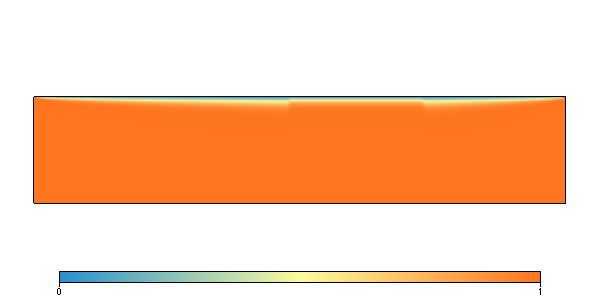

In [20]:
fig = glucifer.Figure(figsize=(600, 300))
fig.append( glucifer.objects.Surface(tg.mesh, plateTempProxFn))
fig.show()

## Make swarm and Slabs

In [57]:
swarm = uw.swarm.Swarm(mesh=mesh, particleEscape=True)
layout = uw.swarm.layouts.PerCellRandomLayout(swarm=swarm, particlesPerCell=int(20))
swarm.populate_using_layout( layout=layout ) # Now use it to populate.
proxyTempVariable = swarm.add_variable( dataType="double", count=1 )
proximityVariable      = swarm.add_variable( dataType="int", count=1 )
signedDistanceVariable = swarm.add_variable( dataType="double", count=1 )

#
proxyTempVariable.data[:] = 1.0
proximityVariable.data[:] = 0.0
signedDistanceVariable.data[:] = 0.0


In [58]:

def tm_uw_map(tempField, velField, mainswarm, signedDistanceVar, proxyTempVar, proximityVar):
    
    mapDict = {}
    mapDict['tempField'] = tempField
    mapDict['velField'] = velField
    mapDict['mainswarm'] = mainswarm
    mapDict['signedDistanceVar'] = signedDistanceVar
    mapDict['proxyTempVar'] = proxyTempVar
    mapDict['proximityVar'] = proximityVar
    return mapDict



In [59]:
#All of these wil be needed by the slab / fault setup functions
#We have two main options, bind them to the TectModel class. 
#or provide them to the functions
#collection them in a dictionary may be a useful way too proviede them to the fucntiosn 
#wthout blowing out the function arguments

tmUwMap = tm_uw_map(temperatureField, velocityField, swarm, 
                    signedDistanceVariable, proxyTempVariable, proximityVariable)


tmUwMap

{'mainswarm': <underworld.swarm._swarm.Swarm at 0x7f2de9356450>,
 'proximityVar': <underworld.swarm._swarmvariable.SwarmVariable at 0x7f2debdbe390>,
 'proxyTempVar': <underworld.swarm._swarmvariable.SwarmVariable at 0x7f2debdbe2d0>,
 'signedDistanceVar': <underworld.swarm._swarmvariable.SwarmVariable at 0x7f2de9356a90>,
 'tempField': <underworld.mesh._meshvariable.MeshVariable at 0x7f2df33e4f10>,
 'velField': <underworld.mesh._meshvariable.MeshVariable at 0x7f2df3418d50>}

In [60]:
def build_slab_distance(plates, gradFn, maxDepth, signedDistanceVar, proxyTempVar):
    

    """
    We're going to build the slab temperature perturbation by mapping from a markerLine to the swarm
    
    """
    
    assert tg.is_subduction_boundary((plates[0], plates[1])), 'not a subduction boundary'   
    
    #determine subduction zone location, direction, etc
    szloc = tg.undirected[plates[0]][plates[1]]['loc']             #Location
    dir_ = tg.subduction_direction((plates[0], plates[1]))           #Direction facing
    normal = [dir_,0.]                                       #Direction facing (as a vector)
    
    spId = tg.subduction_edge_order((plates[0], plates[1]))[0]         #subduction plate Id
    slabage = tg.undirected[plates[0]][plates[1]]['ages'][spId]      #subduction plate Age at the trench
    slabthickness = 2.32*math.sqrt(1.*slabage )              #Diffusive thickness, dimensionless
    plateBounds = np.sort(tg.get_boundaries(spId))
    insidePt = (np.array(plateBounds).mean(), 1 - maxDepth*5)
    
    
    

    ds = (tg.maxX - tg.minX)/(5.*tg.mesh.elementRes[0])     #distance between points 
    #make the slab data
    slabdata = slab_top([szloc, 1.0], normal, gradFn, ds, maxDepth, tg.mesh) #Build the top of slab line
    #return slabdata
    

    
    #build the marker Line
    id_ = -99 #in this case, just a dummy value
    slabLine = markerLine2D(mesh, velocityField, slabdata[:,0], slabdata[:,1], 
                            slabthickness, id_, insidePt=insidePt)
    
    #print (1. - slabLine.swarm.particleCoordinates.data[:,1].min())*2900
    
    #map to signed distance
    
    sd, pts = slabLine.compute_signed_distance(swarm.particleCoordinates.data, distance=2.*slabthickness)
    signedDistanceVar.data[np.logical_and(sd>0, sd<=slabLine.thickness)] = \
    sd[np.logical_and(sd>0, sd<=slabLine.thickness)]
    
    #Now apply the depth cutoff 
    signedDistanceVar.data[swarm.particleCoordinates.data[:,1] < (1. - maxDepth)] = 0.0
        
    
   
def build_slab_temp(signedDistanceVar, proxyTempVar):
    
    #map to proxyTempVariable
    
    #a numpy array
    slabTempProx  = ndp.potentialTemp*fn.math.erf((signedDistanceVar)/(2.*np.sqrt(1.*ndp.slabMaxAge)))
    
    
    conditions = [ ( slabTempProx > 0.1, slabTempProx ), 
                   ( True, proxyTempVar)] 

    proxyTempVar.data[:] = fn.branching.conditional( conditions ).evaluate(swarm)
    
    
    

    
    

In [61]:
def build_fault(plates, gradFn, maxDepth,offset, signedDistanceVar, proxyTempVar):
    

    """
    We're going to build the slab temperature perturbation by mapping from a markerLine to the swarm
    
    """
    
    assert tg.is_subduction_boundary((plates[0], plates[1])), 'not a subduction boundary'   
    
    #determine subduction zone location, direction, etc
    szloc = tg.undirected[plates[0]][plates[1]]['loc']             #Location
    dir_ = tg.subduction_direction((plates[0], plates[1]))           #Direction facing
    normal = [dir_,0.]                                       #Direction facing (as a vector)
    
    spId = tg.subduction_edge_order((plates[0], plates[1]))[0]         #subduction plate Id
    slabage = tg.undirected[plates[0]][plates[1]]['ages'][spId]      #subduction plate Age at the trench
    slabthickness = 2.32*math.sqrt(1.*slabage )              #Diffusive thickness, dimensionless
    plateBounds = np.sort(tg.get_boundaries(spId))
    insidePt = (np.array(plateBounds).mean(), 1 - maxDepth*5)
    

    ds = (tg.maxX - tg.minX)/(5.*tg.mesh.elementRes[0])
    #make the slab data
    slabdata = slab_top([szloc, 1.0 - offset], normal, gradFn, ds, maxDepth, tg.mesh)
    
    
    
    plateDataXs = np.arange(plateBounds[0], plateBounds[1], ds)
    
    plateDataYs = (1.0 - offset)*np.ones(len(plateDataXs))
    plateData = np.column_stack((plateDataXs, plateDataYs))
    
    #print(plateBounds[0], plateBounds[1])
    
    faultData = np.row_stack((plateData, slabdata))
    print(plateData.shape, slabdata.shape)
    
    #build the marker Line
    fault = markerLine2D(mesh, velocityField, faultData[:,0], faultData[:,1], 
                            slabthickness, spId, insidePt=insidePt)
    
   # with fault.swarm.deform_swarm():
   #     fault.swarm.particleCoordinates.data[:] += fault.director.data*offset
    
    return fault

In [71]:
fCollection = line_collection([])

for e in tg.undirected.edges():
    if tg.is_subduction_boundary(e):
        build_slab_distance(e, linearGradientFn, ndp.maxDepth, signedDistanceVariable, proxyTempVariable)
        temp = build_fault(e, linearGradientFn, ndp.maxDepth, ndp.faultThickness, signedDistanceVariable, proxyTempVariable)
        fCollection.append(temp)
#
build_slab_temp(signedDistanceVariable, proxyTempVariable)
fnJointTemp = fn.misc.min(proxyTempVariable,plateTempProxFn)

((1383, 2), (124, 2))
((772, 2), (124, 2))


In [72]:
#build_slab_distance((1,2), linearGradientFn, ndp.maxDepth, signedDistanceVariable, proxyTempVariable)
#build_slab_distance((2,3), linearGradientFn, ndp.maxDepth,signedDistanceVariable, proxyTempVariable )


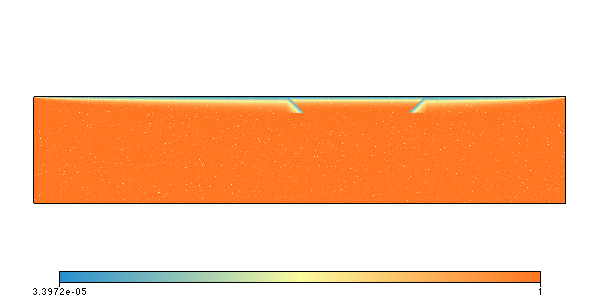

In [73]:
fig = glucifer.Figure(figsize=(600, 300))
fig.append( glucifer.objects.Points(swarm, fnJointTemp))
    

fig.show()
#fig.save_database('test.gldb')

False
True
True
False


In [49]:
ft = build_fault((1,2), linearGradientFn, ndp.maxDepth, ndp.faultThickness, signedDistanceVariable, proxyTempVariable)

((1383, 2), (124, 2))


In [50]:
ft.ID

1


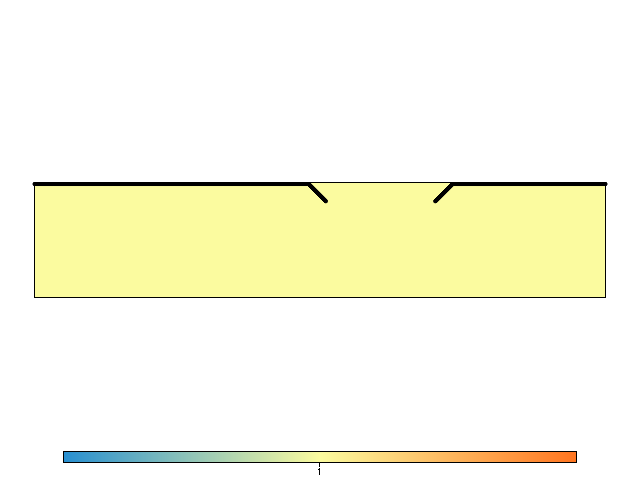

In [75]:
fig2 = glucifer.Figure()
#fig2.append( glucifer.objects.Points(swarm, fnJointTemp, pointSize=0.01))

for f in fCollection:
    fig2.append( glucifer.objects.Points(f.swarm, pointSize=5))

fig2.append( glucifer.objects.Surface(mesh, fn.misc.constant(1)))

fig2.show()
#fig2.save_database('test.gldb')